In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import os

In [2]:
def load_csv(csv_path):
    data = pd.read_csv(csv_path)
    print(f"Loaded {len(data)} rows")
    return data

In [3]:
def filter_markers(data):
    marker_data = {}
    for marker_id in data['marker_id'].unique():
        if marker_id == 0:  # Skip marker 0
            continue
        marker_df = data[data['marker_id'] == marker_id]
        marker_data[marker_id] = marker_df[['timestamp_sec', 'x_3d_mm', 'y_3d_mm', 'z_3d_mm']].copy()
        print(f"Marker {marker_id}: {len(marker_data[marker_id])} points")
    return marker_data

In [4]:
def plot_marker(marker_id, marker_data, fitted_data=None):
    data = marker_data[marker_id]

    plt.figure(figsize=(10, 6))
    plt.plot(data['timestamp_sec'], data['x_3d_mm'], 'o-', label='x_3d_mm', markersize=3)
    plt.plot(data['timestamp_sec'], data['y_3d_mm'], 'o-', label='y_3d_mm', markersize=3)
    plt.plot(data['timestamp_sec'], data['z_3d_mm'], 'o-', label='z_3d_mm', markersize=3)

    if fitted_data and marker_id in fitted_data:
        fit = fitted_data[marker_id]
        times = data['timestamp_sec'].values
        plt.plot(times, fit['x_slope'] * times + fit['x_intercept'], '--', linewidth=2)
        plt.plot(times, fit['y_slope'] * times + fit['y_intercept'], '--', linewidth=2)
        plt.plot(times, fit['z_slope'] * times + fit['z_intercept'], '--', linewidth=2)

    plt.xlabel('time[s]')
    plt.ylabel('distance[mm]')
    plt.title(f'Marker {marker_id}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'marker_{marker_id}_plot.png', dpi=150)
    plt.show()

In [5]:
def fit_linear_data(marker_data):
    fitted_data = {}

    for marker_id, data in marker_data.items():
        times = data['timestamp_sec'].values
        x_vals = data['x_3d_mm'].values
        y_vals = data['y_3d_mm'].values
        z_vals = data['z_3d_mm'].values

        x_slope, x_intercept, _, _, _ = stats.linregress(times, x_vals)
        y_slope, y_intercept, _, _, _ = stats.linregress(times, y_vals)
        z_slope, z_intercept, _, _, _ = stats.linregress(times, z_vals)

        avg_time = np.mean(times)

        fitted_data[marker_id] = {
            'x_slope': x_slope,
            'x_intercept': x_intercept,
            'y_slope': y_slope,
            'y_intercept': y_intercept,
            'z_slope': z_slope,
            'z_intercept': z_intercept,
            'x_fitted': x_slope * avg_time + x_intercept,
            'y_fitted': y_slope * avg_time + y_intercept,
            'z_fitted': z_slope * avg_time + z_intercept
        }

        print(f"\nMarker {marker_id}:")
        print(f"  X = {x_slope:.4f}x + {x_intercept:.2f}")
        print(f"  Y = {y_slope:.4f}x + {y_intercept:.2f}")
        print(f"  Z = {z_slope:.4f}x + {z_intercept:.2f}")
        print(f"  Position: ({fitted_data[marker_id]['x_fitted']:.2f}, {fitted_data[marker_id]['y_fitted']:.2f}, {fitted_data[marker_id]['z_fitted']:.2f})")

    return fitted_data


In [6]:
def calculate_tilt_with_three_points(fitted_data):
    """Calculate tilt using any 3 available markers from 1-4"""
    available_markers = sorted([m for m in fitted_data.keys() if m in [1, 2, 3, 4]])

    if len(available_markers) < 3:
        print(f"Error: Need at least 3 markers. Only found: {available_markers}")
        return None

    # Use first 3 available markers
    m1_id, m2_id, m3_id = available_markers[:3]

    print(f"\nUsing markers {m1_id}, {m2_id}, {m3_id} for calculation")

    m1 = fitted_data[m1_id]
    m2 = fitted_data[m2_id]
    m3 = fitted_data[m3_id]

    # Create two vectors from the three points
    r1 = np.array([
        m2['x_fitted'] - m1['x_fitted'],
        m2['y_fitted'] - m1['y_fitted'],
        m2['z_fitted'] - m1['z_fitted']
    ])

    r2 = np.array([
        m3['x_fitted'] - m1['x_fitted'],
        m3['y_fitted'] - m1['y_fitted'],
        m3['z_fitted'] - m1['z_fitted']
    ])

    # Normal vector
    n_raw = np.cross(r1, r2)
    n_magnitude = np.linalg.norm(n_raw)
    n = n_raw / n_magnitude

    # Tilt angle
    k = np.array([0, 0, -1])
    dot_product = np.dot(n, k)
    theta_rad = np.arccos(np.abs(dot_product))
    theta_deg = np.degrees(theta_rad)

    # Direction vector
    d_raw = np.cross(k, n)
    d_magnitude = np.linalg.norm(d_raw[:2])
    d = d_raw / d_magnitude if d_magnitude > 0 else d_raw

    # Azimuth
    phi_rad = np.arctan2(-n[0], n[1])
    phi_deg = np.degrees(phi_rad)

    return {
        'markers_used': [m1_id, m2_id, m3_id],
        'r1': r1,
        'r2': r2,
        'n_raw': n_raw,
        'n_magnitude': n_magnitude,
        'n': n,
        'theta_deg': theta_deg,
        'theta_rad': theta_rad,
        'd': d,
        'phi_deg': phi_deg,
        'phi_rad': phi_rad
    }

In [7]:
def print_results(results):
    if results is None:
        print("No results to display")
        return

    print("\n" + "="*60)
    print("RESULTS")
    print("="*60)

    print(f"\nMarkers used: {results['markers_used']}")

    print(f"\nr1: [{results['r1'][0]:.3f}, {results['r1'][1]:.3f}, {results['r1'][2]:.3f}]")
    print(f"r2: [{results['r2'][0]:.3f}, {results['r2'][1]:.3f}, {results['r2'][2]:.3f}]")

    print(f"\nNormal vector (raw): [{results['n_raw'][0]:.2f}, {results['n_raw'][1]:.2f}, {results['n_raw'][2]:.2f}]")
    print(f"Magnitude: {results['n_magnitude']:.4f}")
    print(f"Normalized: [{results['n'][0]:.11f}, {results['n'][1]:.11f}, {results['n'][2]:.10f}]")

    print(f"\nTilt Angle: {results['theta_deg']:.6f} degrees")
    print(f"Azimuth: {results['phi_deg']:.2f} degrees")
    print(f"Direction: [{results['d'][0]:.10f}, {results['d'][1]:.10f}, {results['d'][2]:.1f}]")
    print("="*60 + "\n")

In [8]:
def analyze_air_bearing(csv_path, plot_markers=True):
    print("Starting analysis...")

    data = load_csv(csv_path)
    marker_data = filter_markers(data)

    if len(marker_data) < 3:
        print(f"Error: Need at least 3 markers. Only found {len(marker_data)} markers")
        return None

    fitted_data = fit_linear_data(marker_data)

    if plot_markers:
        for marker_id in marker_data.keys():
            plot_marker(marker_id, marker_data, fitted_data)

    results = calculate_tilt_with_three_points(fitted_data)
    print_results(results)

    return results

In [9]:
def list_csv_files(folder_path):
    """List all CSV files in the folder"""
    files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
    return files

In [10]:
def run_interactive_analysis():
    """Interactive function to upload and analyze a CSV file"""
    from google.colab import files

    # Upload file
    print("Please upload your CSV file:")
    uploaded = files.upload()

    # Get the uploaded filename
    csv_filename = list(uploaded.keys())[0]
    csv_path = f'/content/{csv_filename}'

    print(f"\nAnalyzing file: {csv_filename}")
    print("-" * 60)

    # Run analysis
    results = analyze_air_bearing(csv_path, plot_markers=True)

    return results

Please upload your CSV file:


Saving +5X+FY.csv to +5X+FY.csv

Analyzing file: +5X+FY.csv
------------------------------------------------------------
Starting analysis...
Loaded 2345 rows
Marker 3: 469 points
Marker 2: 469 points
Marker 4: 469 points
Marker 1: 469 points

Marker 3:
  X = -0.0061x + 271.13
  Y = 0.0023x + -104.41
  Z = -0.0217x + 966.21
  Position: (271.10, -104.40, 966.09)

Marker 2:
  X = 0.0064x + 112.99
  Y = 0.0063x + 110.22
  Z = 0.0549x + 961.73
  Position: (113.03, 110.25, 962.02)

Marker 4:
  X = 0.0037x + 45.72
  Y = -0.0220x + -260.60
  Z = 0.0816x + 960.98
  Position: (45.74, -260.72, 961.42)

Marker 1:
  X = -0.0181x + -103.19
  Y = -0.0071x + -39.01
  Z = 0.1701x + 957.51
  Position: (-103.29, -39.05, 958.43)


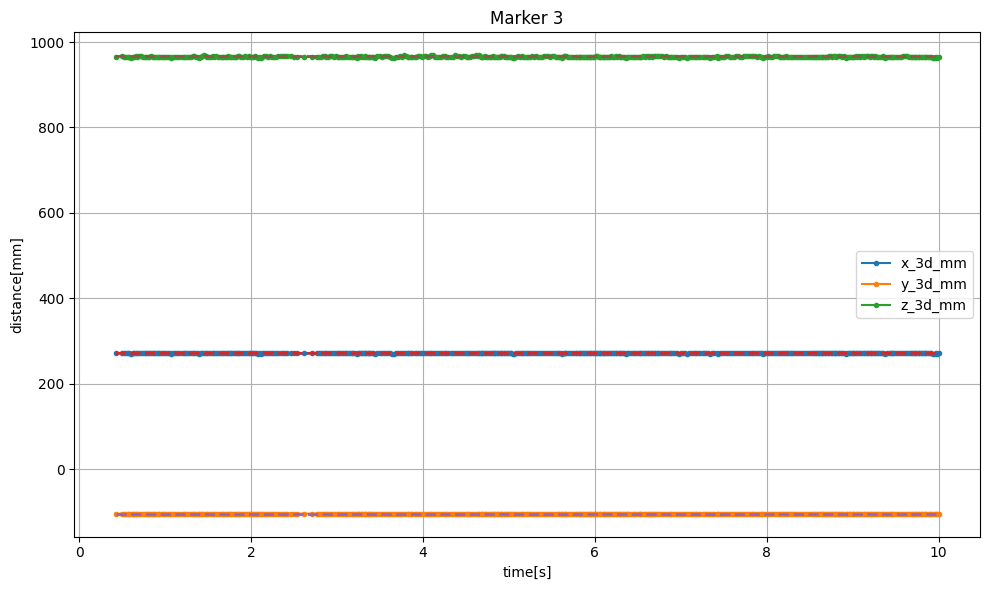

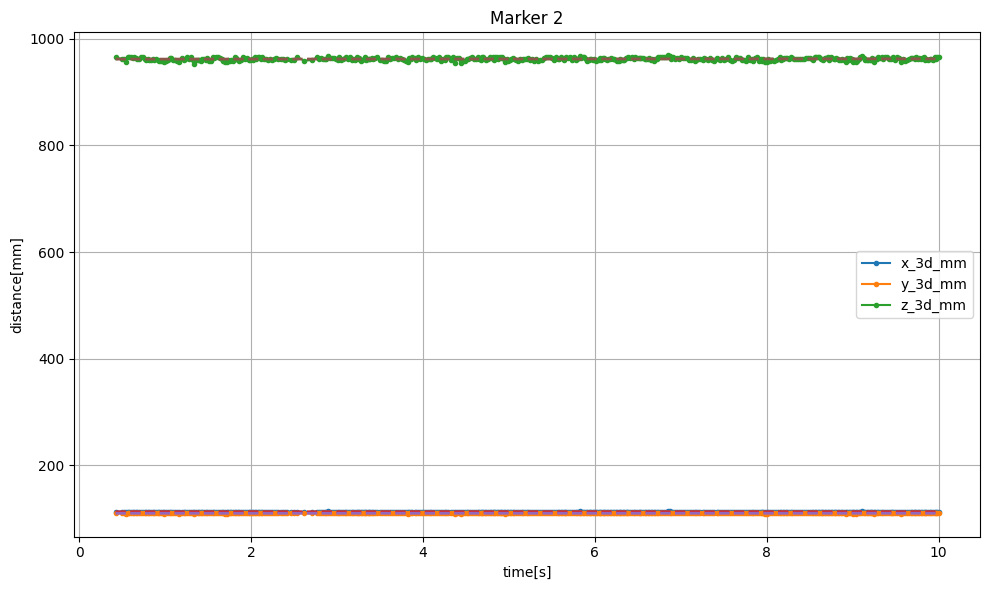

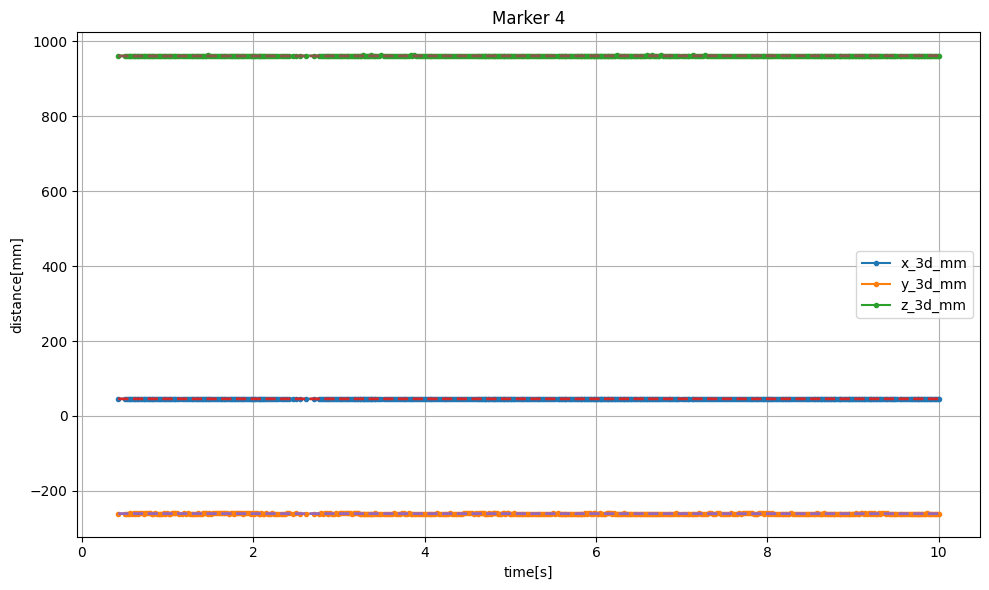

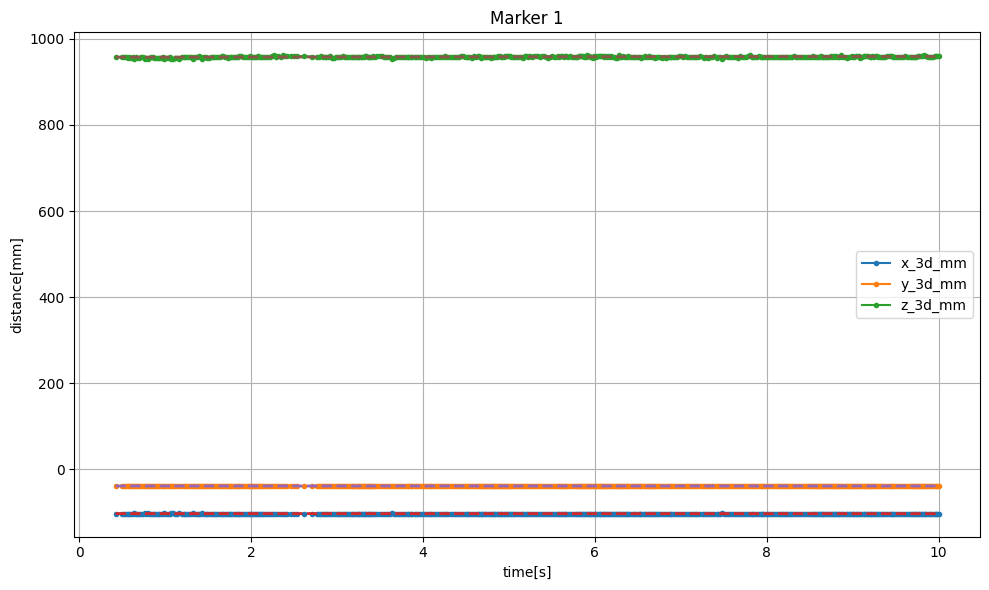


Using markers 1, 2, 3 for calculation

RESULTS

Markers used: [np.int64(1), np.int64(2), np.int64(3)]

r1: [216.316, 149.304, 3.593]
r2: [374.387, -65.351, 7.663]

Normal vector (raw): [1378.92, -312.58, -70033.89]
Magnitude: 70048.1646
Normalized: [0.01968536540, -0.00446232800, -0.9997962663]

Tilt Angle: 1.156582 degrees
Azimuth: -102.77 degrees
Direction: [-0.2210737249, -0.9752570985, -0.0]



In [11]:
results = run_interactive_analysis()